In [1]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from time import time

In [3]:
use_cuda = torch.cuda.is_available()
print('cuda', use_cuda)

cuda True


In [70]:
def plot_digits(*args):
    n = min([x.size(0) for x in args])
    args = [x.cpu().data.numpy().squeeze() for x in args]
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

In [115]:
# Гомотопия по прямой между объектами или между кодами
def plot_homotopy(frm, to, n=10, decoder=None):
    z = torch.zeros(([n] + list(frm.size())))
    if use_cuda:
        z = z.cuda()
    for i, t in enumerate(np.linspace(0., 1., n)):
        z[i] = frm * (1-t) + to * t
    if decoder:
        plot_digits(sigm(decoder(z)))
    else:
        plot_digits(z)

In [5]:
train_cifar = dset.CIFAR10(root='cifar', train=True, transform=transforms.ToTensor(), download=True)
test_cifar = dset.CIFAR10(root='cifar', train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# if not exist, download mnist dataset
train_set = dset.MNIST(root='../mnist', train=True, transform=transforms.ToTensor(), download=True)
test_set = dset.MNIST(root='../mnist', train=False, transform=transforms.ToTensor(), download=True)

In [46]:
sigm = nn.Sigmoid()
def draw(imgs):
    with torch.no_grad():
        imgs = torch.cat(imgs)
        if use_cuda:
            imgs = imgs.cuda()
        y = model.forward(imgs.unsqueeze(1))
        y = sigm(y)
        decoded_imgs = y
        plot_digits(imgs, decoded_imgs)

In [105]:
class DenseAE(nn.Module):
    def __init__(self):
        super().__init__()
        encoding_dim = 49
        
        self.encoder = nn.Linear(28*28, encoding_dim)
        self.relu = nn.ReLU()
        self.decoder = nn.Linear(encoding_dim, 28*28)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        code = self.relu(self.encoder(x))
        decoded = self.decoder(code)
        return decoded.view(-1, 1, 28, 28)
    
    def count_parameters(self, module=None):
        if module is None:
            module = self
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    
model = DenseAE()
if use_cuda:
    model = model.cuda()
print(model.count_parameters())


77665


In [ ]:
class DenseAEDeep(nn.Module):
    def __init__(self):
        super().__init__()
        encoding_dim = 49
        
        self.encoder1 = nn.Linear(28*28, encoding_dim*3)
        self.relu1 = nn.ReLU()
        self.encoder2 = nn.Linear(encoding_dim*3, encoding_dim*2)
        self.relu2 = nn.ReLU()
        self.encoder = nn.Linear(encoding_dim*2, encoding_dim)
        
        self.decoder1 = nn.Linear(encoding_dim, encoding_dim*2)
        self.drelu1 = nn.ReLU()
        self.decoder2 = nn.Linear(encoding_dim*2, encoding_dim*3)
        self.drelu2 = nn.ReLU()
        self.decoder = nn.Linear(encoding_dim*3, 28*28)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu1(self.encoder1(x))
        x = self.relu2(self.encoder2(x))
        code = self.encoder(x)
        
        x = self.drelu1(self.decoder1(code))
        x = self.drelu2(self.decoder2(x))
        decoded = self.decoder(x)
        
        return decoded.view(-1, 1, 28, 28)
    
    def count_parameters(self, module=None):
        if module is None:
            module = self
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    
model = DenseAEDeep()
if use_cuda:
    model = model.cuda()
print(model.count_parameters())

In [119]:
class ConvAE(nn.Module):
    def __init__(self):
        super().__init__()
        encoding_dim = 49
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 90, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(90, 32, 5, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=(2, 2)),
            nn.Conv2d(32, 90, 5, padding=2),
            nn.ReLU(True),
            nn.Upsample(scale_factor=(2, 2)),
            nn.Conv2d(90, 1, 3, padding=1),
        )


    def forward(self, x):
        code = self.encoder(x)
        return self.decoder(code)

    
    def count_parameters(self, module=None):
        if module is None:
            module = self
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    
model = ConvAE()
if use_cuda:
    model = model.cuda()
print(model.count_parameters())

146442


In [120]:
print(model.__class__, model.count_parameters())
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

<class '__main__.ConvAE'> 146442


In [35]:
epochs = 50
batch_size = 256

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

print('total training batches: {}'.format(len(train_loader)))
print('total testing batches: {}'.format(len(test_loader)))

total training batches: 235
total testing batches: 40


In [26]:
def noise(x, factor=0.5):
    n = torch.zeros(x.size())
    n.normal_(0.5, factor)
    x = x + n
    return x.clamp(0,1)

In [36]:
def test(model, test_loader, epoch):
    model.eval()
    with torch.no_grad():
        test_loss = []
        for batch_idx, (x, target) in enumerate(test_loader):
            target = x
            if use_cuda:
                x, target = x.cuda(), target.cuda()
            out = model(x)
            loss = criterion(out, target)
            test_loss.append(loss.cpu().item())
    model.train()
    return np.mean(test_loss)

In [28]:
# for param_group in optimizer.param_groups:
#         param_group['lr'] = 0.0001

In [29]:
import warnings
warnings.filterwarnings("ignore")

In [123]:
%%time
# train
print(model.__class__, model.count_parameters())
for epoch in range(epochs):
    dt = time()
    train_loss = []
    for batch_idx, (x, target) in enumerate(train_loader):
        target = x
        optimizer.zero_grad()
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        out = model(x)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.cpu().item())
        if (batch_idx+1) % 20 == 0 or (batch_idx+1) == len(train_loader):
            print('epoch %d, train loss %.4f' % (epoch, np.mean(train_loss)))
    test_loss = test(model, test_loader, epoch)
    train_loss = np.mean(train_loss)
    print('epoch %d, train loss %.4f, test loss %.4f, time %3.1fs' % (epoch, train_loss, test_loss, time()-dt))
    

<class '__main__.ConvAE'> 146442
epoch 0, train loss 0.0957
epoch 0, train loss 0.0949
epoch 0, train loss 0.0937
epoch 0, train loss 0.0931
epoch 0, train loss 0.0925
epoch 0, train loss 0.0919
epoch 0, train loss 0.0915
epoch 0, train loss 0.0910
epoch 0, train loss 0.0906
epoch 0, train loss 0.0903
epoch 0, train loss 0.0900
epoch 0, train loss 0.0898
epoch 0, train loss 0.0898, test loss 0.0846, time 15.8s
epoch 1, train loss 0.0854
epoch 1, train loss 0.0855
epoch 1, train loss 0.0855
epoch 1, train loss 0.0854
epoch 1, train loss 0.0854
epoch 1, train loss 0.0851
epoch 1, train loss 0.0849
epoch 1, train loss 0.0847
epoch 1, train loss 0.0846
epoch 1, train loss 0.0844
epoch 1, train loss 0.0843
epoch 1, train loss 0.0842
epoch 1, train loss 0.0842, test loss 0.0816, time 15.6s
epoch 2, train loss 0.0828
epoch 2, train loss 0.0828
epoch 2, train loss 0.0826
epoch 2, train loss 0.0824
epoch 2, train loss 0.0822
epoch 2, train loss 0.0822
epoch 2, train loss 0.0821
epoch 2, train l

epoch 21, train loss 0.0736
epoch 21, train loss 0.0736
epoch 21, train loss 0.0739
epoch 21, train loss 0.0739
epoch 21, train loss 0.0738
epoch 21, train loss 0.0738
epoch 21, train loss 0.0737
epoch 21, train loss 0.0737
epoch 21, train loss 0.0737
epoch 21, train loss 0.0737
epoch 21, train loss 0.0737
epoch 21, train loss 0.0737, test loss 0.0731, time 16.9s
epoch 22, train loss 0.0736
epoch 22, train loss 0.0739


KeyboardInterrupt: 

In [124]:
test(model, test_loader, epoch)

0.07286475673317909

In [158]:
torch.save(model.state_dict(), 'convAE_params146442_loss07286.pth')

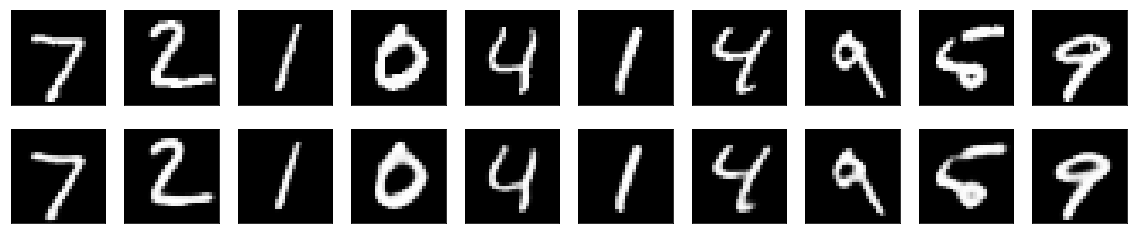

In [159]:
n = 10
imgs = [t for t,l in test_set][:10]
draw(imgs)

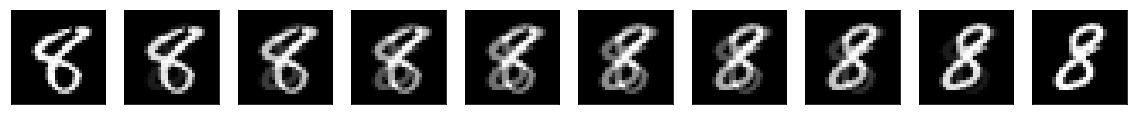

In [140]:
frm, to = [t for t,l in test_set if l==8][1:3]
plot_homotopy(frm, to)

In [161]:
x = torch.cat([frm,to]).unsqueeze(1).cuda()
codes = model.encoder(x)
codes.size()

torch.Size([2, 1, 7, 7])

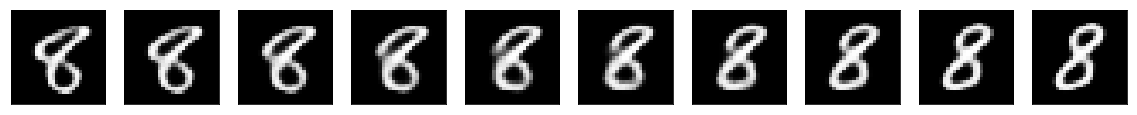

In [162]:
plot_homotopy(codes[0], codes[1], n=10, decoder=model.decoder)

In [143]:
x_test = torch.cat([t for t,l in test_set]).unsqueeze(1).cuda()
x_test.size()

torch.Size([10000, 1, 28, 28])

In [151]:
# codes = model.encoder(x_test)
codes = codes.cpu().view(-1,49).detach().numpy()
codes.shape

(10000, 49)

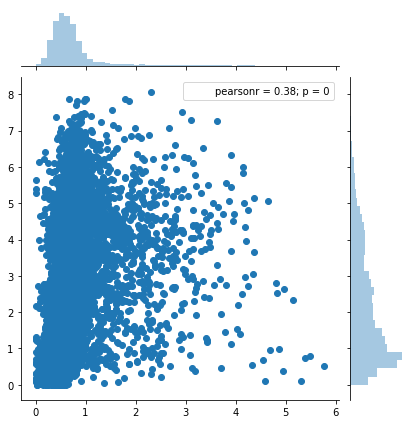

In [157]:
sns.jointplot(codes[:,1], codes[:,3])